This notebook follows this tutorial by mlflow here : https://mlflow.org/docs/latest/traditional-ml/hyperparameter-tuning-with-child-runs/index.html

In [2]:
#import necessary libraries 
from datetime import datetime, timedelta
import math

import numpy as np
import optuna 
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

import mlflow

c:\Users\sabie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mlflow.set_tracking_uri("http://localhost:8080")


In [4]:
df = pd.read_csv("Clean_Dataset.csv")

In [5]:
df.dtypes

Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

In [6]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [7]:
df.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

list of changing object dtypes to ints \\
airline we can one hot encode\\
drop flight from training does not seem relevant \\
source city one hot encode\\
departure times label encode
stops label encode
arrival time label encode
destination city one hot encode
class label encode



In [23]:
label_cols = ['class', 'arrival_time', 'stops', 'departure_time']
one_hot_cols = ['destination_city', 'source_city', 'airline']

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(), one_hot_cols),
        ('label', LabelEncoder(), label_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

X = df[['airline', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left']]
y = df['price'].astype('float')
X = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


TypeError: LabelEncoder.fit_transform() takes 2 positional arguments but 3 were given

In [8]:

for column in df.columns:
    value_counts = df[column].value_counts()
    print(f"Value counts for {column}:\n{value_counts}\n")

Value counts for Unnamed: 0:
Unnamed: 0
0         1
200091    1
200107    1
200106    1
200105    1
         ..
100050    1
100049    1
100048    1
100047    1
300152    1
Name: count, Length: 300153, dtype: int64

Value counts for airline:
airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

Value counts for flight:
flight
UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: count, Length: 1561, dtype: int64

Value counts for source_city:
source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

Value counts for departure_time:
departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Nigh

In [16]:
#creating a correlation feature vs target plot using seaborn

import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_with_demand(df, save_path=None):
    correlations = df.corr()["demand"].drop("demand").sort_values()
    
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)
    
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )
    
    fig = plt.figure(figsize=(12, 8))
    bars = plt.barh(correlations.index, correlations.values, color=color_mapped)
    
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")
    
    plt.tight_layout()
      
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)
    
    plt.close(fig)
    return fig
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")

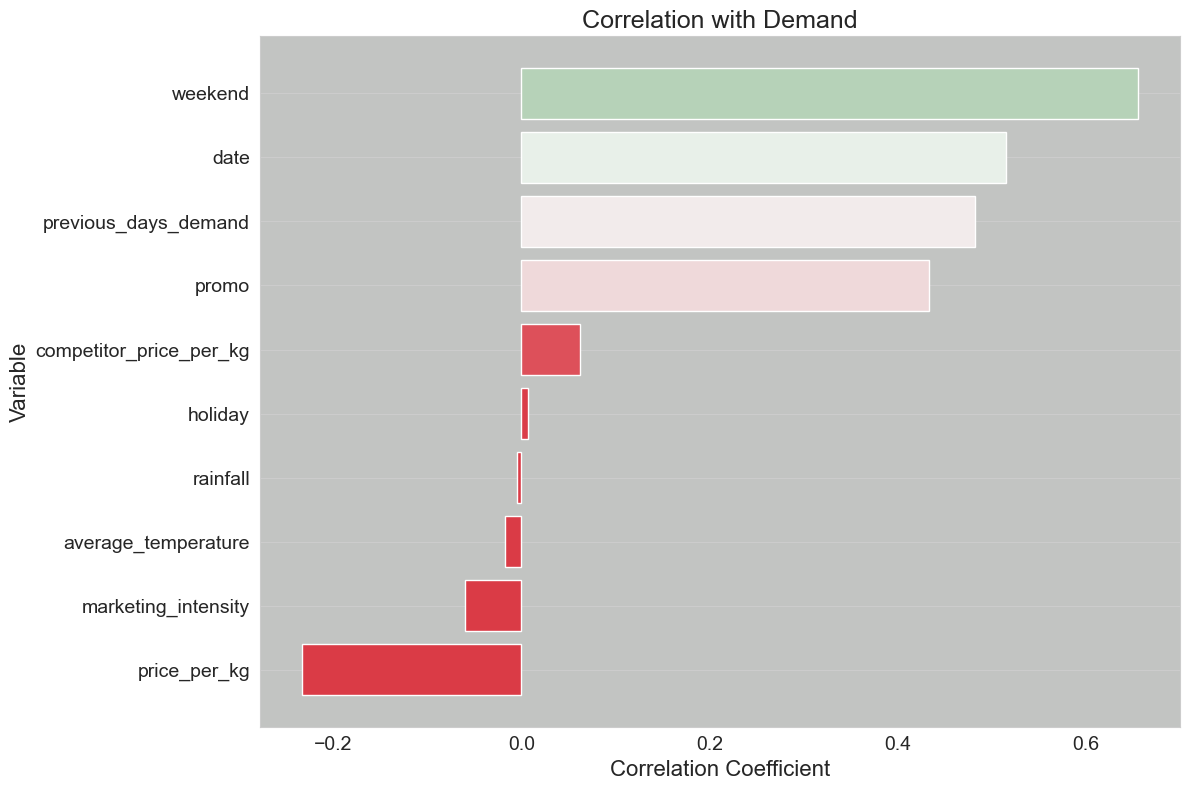

In [15]:
correlation_plot

In [17]:
#plotting residuals to show information on how well the model is predicting

def plot_residuals(model, dvalid, valid_y, save_path=None):
    preds = model.predict(dvalid)
    
    residuals = valid_y - preds
    
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})
    
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")
    
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)
        
    plt.close(fig)
    
    return fig

In [21]:
#plotting feature importance for xgb

def plot_feature_importance(model, booster):
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_type = "weight" if booster == "gblinear" else "gain"
    xgb.plot_importance(
        model, 
        importance_type=importance_type,
        ax=ax,
        title=f"Feature Importance based on {importance_type}",
    )
    plt.tight_layout()
    plt.close(fig)
    
    return fig

In [22]:
#create/get experiment function
def get_or_create_experiment(experiment_name):
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

In [23]:
experiment_id = get_or_create_experiment("Apples Demand")

In [24]:
experiment_id

'952898099202036929'

In [25]:
mlflow.set_experiment(experiment_id=experiment_id)

X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

In [26]:
#creating optuna functions
optuna.logging.set_verbosity(optuna.logging.ERROR)

def champion_callback(study, frozen_trial):
    winner = study.user_attrs.get("winner", None)
    
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                  f"{improvement_percent:.4f}% improvement"
                  )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [28]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }
        
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)
        
        #log to mlflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))
        
        return error

In [29]:
run_name = "first_attempt"

In [38]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    study = optuna.create_study(direction="minimize")
    
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])
    
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))
    
    mlflow.set_tags(
        tags={
            "project":"Apple Demand Project", 
            "optimizer_engine":"optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )
    
    model = xgb.train(study.best_params, dtrain)
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")
    
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")
    
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")
    
    artifact_path = "model"
    
    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )
    
    model_uri = mlflow.get_artifact_uri(artifact_path)

Initial trial 0 achieved value: 18973.42718962212
Trial 7 achieved value: 17303.885795774622 with 9.6484% improvement
Trial 10 achieved value: 16965.22812395761 with 1.9962% improvement
Trial 11 achieved value: 16415.894628891223 with 3.3464% improvement
Trial 12 achieved value: 15118.05186974232 with 8.5847% improvement
Trial 39 achieved value: 15005.087870918995 with 0.7528% improvement
Trial 41 achieved value: 14844.990545010703 with 1.0785% improvement
Trial 101 achieved value: 14780.104035578788 with 0.4390% improvement
Trial 462 achieved value: 14747.032572715196 with 0.2243% improvement


c:\Users\sabie\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [39]:
model_uri

'mlflow-artifacts:/952898099202036929/c061b597526f4372af85eb6f6638938a/artifacts/model'

In [40]:
loaded = mlflow.xgboost.load_model(model_uri)

In [41]:
loaded = mlflow.xgboost.load_model(model_uri)

In [42]:
batch_dmatrix = xgb.DMatrix(X)
inference = loaded.predict(batch_dmatrix)

infer_df = df.copy()
infer_df["predicted_demand"] = inference

In [43]:
infer_df

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity,predicted_demand
0,2010-05-23 22:00:06.542035,30.584727,1.199291,1,0,1.726258,0,1151.375336,1151.276659,1.935346,0.098677,1423.208008
1,2010-05-24 22:00:06.542035,15.465069,1.037626,0,0,0.576471,0,906.855943,1151.276659,2.344720,0.019318,1177.627075
2,2010-05-25 22:00:06.542035,10.786525,5.656089,0,0,2.513328,0,808.304909,906.836626,0.998803,0.409485,894.911743
3,2010-05-26 22:00:06.542035,23.648154,12.030937,0,0,1.839225,0,799.833810,857.895424,0.761740,0.872803,905.732849
4,2010-05-27 22:00:06.542035,13.861391,4.303812,0,0,1.531772,0,983.949061,848.961007,2.123436,0.820779,1008.438049
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-01-25 22:00:06.536001,21.643051,3.821656,0,0,2.391010,0,1165.882437,1170.799278,1.504432,0.756489,1046.079956
4996,2024-01-26 22:00:06.536001,13.808813,1.080603,0,1,0.898693,0,1312.870527,1215.125948,1.343586,0.742145,1182.114014
4997,2024-01-27 22:00:06.536001,11.698227,1.911000,1,0,2.839860,0,1413.065524,1312.128382,2.771896,0.742145,1371.170898
4998,2024-01-28 22:00:06.536001,18.052081,1.000521,1,0,1.188440,0,1823.886638,1462.323379,2.564075,0.742145,1495.107788


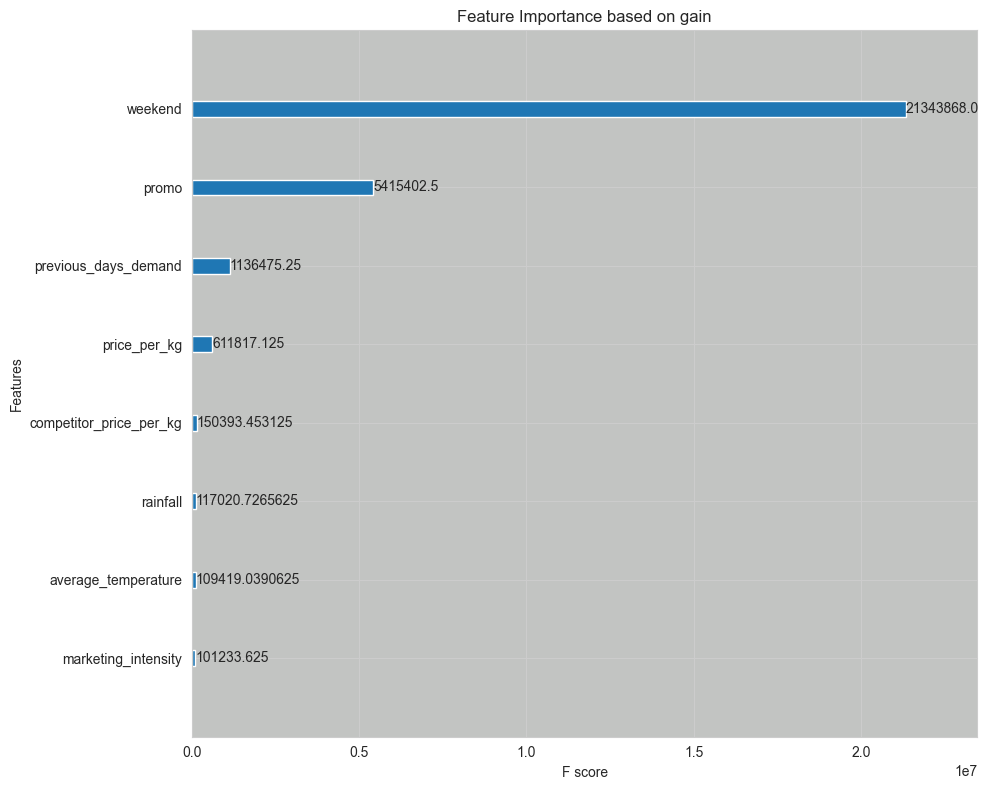

In [37]:
importances